# Simulations of effective dose on a surface


Effective dose is used to assess the potential for long-term effects that might occur in the future.

Effective dose provides a sinlge number that reflects the exposure to radiation. To quote ICRP who deffine the quantity "It sums up any number of different exposures into a single number that reflects, in a general way, the overall risk"

Effective dose is a calculated value, measured in milli Sv. Effective dose is calculated for the whole body. The sum of equivalent doses to all organs, each adjusted to account for the sensitivity of the organ to radiation. Read more about equivalent dose, absorbed dose and effective dose on the ICRP website.

http://icrpaedia.org/Absorbed,_Equivalent,_and_Effective_Dose

The amount of effective dose deposited by a neutron or photon depends on the energy of the particle. The dose coefficients provided by ICRP are energy dependant.

The following section plots the effective dose coefficient as a function of incident particle energy for neutrons and photons

In [12]:
import openmc
import plotly.graph_objects as go

energy_bins_n, dose_coeffs_n = openmc.data.dose_coefficients(particle='neutron', geometry='AP')
energy_bins_p, dose_coeffs_p = openmc.data.dose_coefficients(particle='photon', geometry='AP')

fig = go.Figure()

fig.update_layout(
      title='ICRP Effective Dose Coefficient',
      xaxis={'title': 'Energy (eV)',
             'range': (0, 14.1e6)},
      yaxis={'title': 'Effective dose per fluence, in units of pSv cm²'}
)


fig.add_trace(go.Scatter(
    x=energy_bins_p,
    y=dose_coeffs_p,
    mode='lines',
    name='photon'
))

fig.add_trace(go.Scatter(
    x=energy_bins_n,
    y=dose_coeffs_n,
    mode='lines',
    name='neutron'
))

To find the effective dose on a surface a geometry will be needed along with some materials.

This section makes a geometry and materials which will have a dose tally added to it later

Makes the materials

In [13]:
steel = openmc.Material(name='steel')
steel.set_density('g/cm3', 7.75)
steel.add_element('Fe', 0.95, percent_type='wo')
steel.add_element('C', 0.05, percent_type='wo')

mats = openmc.Materials([steel])

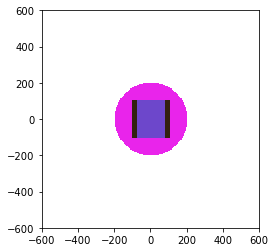

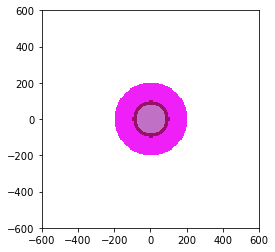

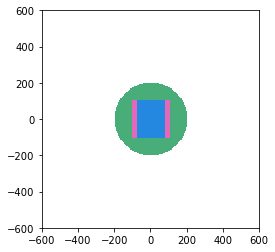

In [14]:
import matplotlib.pyplot as plt

height = 200
thickness = 2

outer_cylinder = openmc.ZCylinder(r=100)
inner_cylinder = openmc.ZCylinder(r=80)
inner_top = openmc.ZPlane(z0=height*0.5)
inner_bottom = openmc.ZPlane(z0=-height*0.5)
outer_top = openmc.ZPlane(z0=height*0.5+thickness)
outer_bottom = openmc.ZPlane(z0=-height*0.5-thickness)
sphere_1 = openmc.Sphere(r=200, boundary_type='vacuum')

#todo add an onion of sphere so dose can be found on each surface

cylinder_region = -outer_cylinder & +inner_cylinder & -inner_top & +inner_bottom
cylinder_cell = openmc.Cell(region=cylinder_region)
cylinder_cell.fill = steel

top_cap_region = -outer_top & +inner_top & -outer_cylinder
top_cap_cell = openmc.Cell(region=top_cap_region)

bottom_cap_region = +outer_bottom & -inner_bottom & -outer_cylinder
bottom_cap_cell = openmc.Cell(region=bottom_cap_region)

inner_void_region = -inner_cylinder & -inner_top & +inner_bottom
inner_void_cell = openmc.Cell(region=inner_void_region)

sphere_1_region = -sphere_1
sphere_1_cell = openmc.Cell(region= sphere_1_region
                            & ~bottom_cap_region
                            & ~top_cap_region
                            & ~cylinder_region
                            & ~inner_void_region
                           )

universe = openmc.Universe(cells=[
    inner_void_cell, cylinder_cell, top_cap_cell,
    bottom_cap_cell, sphere_1_cell])

geom = openmc.Geometry(universe)

plt.show(universe.plot(width=(1200, 1200), basis='xz'))
plt.show(universe.plot(width=(1200, 1200), basis='xy'))
plt.show(universe.plot(width=(1200, 1200), basis='yz'))

Make the source

In [15]:
# SIMULATION SETTINGS

# Instantiate a Settings object
sett = openmc.Settings()
sett.batches = 10
sett.inactive = 0
sett.particles = 500
sett.run_mode = 'fixed source'

# Create a DT point source
source = openmc.Source()
source.space = openmc.stats.Point((0, 0, 0))
source.angle = openmc.stats.Isotropic()
# This is a Co60 source, see the task on sources to understand it
source.energy = openmc.stats.Discrete([1.1732e6,1.3325e6], [0.5, 0.5])
source.particle = 'photon'
sett.source = source



These coeffients can then be used in a neutronics tally with the openmc.EnergyFunctionFilter.

This will effectivly multilpy the particle energy spectra with the effictive dose coefficient to produce a single number for effective dose.

In [16]:
energy_function_filter_n = openmc.EnergyFunctionFilter(energy_bins_n, dose_coeffs_n)
energy_function_filter_p = openmc.EnergyFunctionFilter(energy_bins_p, dose_coeffs_p)

photon_particle_filter = openmc.ParticleFilter(["photon"])
surface_filter = openmc.SurfaceFilter(sphere_1)

tallies = openmc.Tallies()

dose_tally = openmc.Tally(name="dose_tally_on_surface")
dose_tally.scores = ["current"]
dose_tally.filters = [
    surface_filter,
    photon_particle_filter,
    energy_function_filter_p,
]
tallies.append(dose_tally)

This section runs the simulation.

In [17]:
# Run OpenMC!
model = openmc.model.Model(geom, mats, sett, tallies)
!rm *.h5
sp_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [18]:
# open the results file
sp = openmc.StatePoint(sp_filename)

# access the tally using pandas dataframes
tally = sp.get_tally(name='dose_tally_on_surface')
df = tally.get_pandas_dataframe()

tally_result = df['mean'].sum()
tally_std_dev = df['std. dev.'].sum()

convert from the tally output units of pSv cm² to pSv by dividing by the surface area of the surface


# print results
print('The surface dose = ', tally_result, 'Sv')
print('Standard deviation on the tally is ', tally_std_dev)

The surface dose =  6.539309844006477 Sv
Standard deviation on the tally is  0.20577084157344994
